In [1]:
import numpy as np
import pandas as pd
import sys,os
import glob
import scipy.optimize as spo
sys.path.append(sys.path[0] + '/../MeasureMSI/')

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload
import platereaderclass as prc; reload(prc);
import plateimageclass as pic; reload(pic);
import plates_EstimateMSI as eMSI; reload(eMSI);
import PopulationDynamicsClasses as PDC; reload(PDC);


np.seterr(all = 'ignore');

In [2]:
# for internal dynamics
volume_ecoli = 1e-15 # L
volume_well  = 2e-4  # L

eta_ecoli = volume_ecoli/volume_well

# growth parameters
growth_alpha = 1.049
growth_gamma = 1.320
growth_kappa = 7.049

# phi from fit
phi_andy     = 3.783e6
phi_philip   = 9.396e5


# get realistic parameters
def GetRhoEpsilon(tau = 1e6, logratio = 0, eta = 1, return_dict = False):
    ratio = 10**logratio
    eps = np.sqrt(2. / ratio / eta) * growth_alpha * growth_kappa * growth_gamma / (1. + growth_gamma) / tau
    rho = ratio * eps
    if return_dict: return {'rho': rho, 'epsilon': eps}
    else:           return rho, eps


def GetSigmaEB(phi = 1e6, logratio = 0, eta = 1, return_dict = False):
    ratio = 10**logratio
    sigmaE = np.sqrt(2. / ratio / eta) * growth_alpha * growth_kappa * growth_gamma / (1. + growth_gamma) / phi
    sigmaB = ratio * sigmaE
    if return_dict: return {'sigmaE': sigmaE, 'sigmaB': sigmaB}
    else:           return sigmaE, sigmaB


In [3]:
params = {'growthrate': growth_alpha,
          'kappa':      growth_kappa,
          'gamma':      growth_gamma,
          'StoreRuns':  True}

params.update(GetRhoEpsilon(tau = 1e6, return_dict = True))
#params.update(GetSigmaEB(phi = phi_andy, return_dict = True))

params_internal = params.copy()
params_internal['rho'],    params_internal['epsilon'] = GetRhoEpsilon(tau = 1e6, eta=eta_ecoli)
params_internal['sigmaE'], params_internal['sigmaB']  = GetSigmaEB(phi = phi_andy, eta=eta_ecoli)


print(params)
print(params_internal)


phi = params_internal['rho']*params_internal['epsilon']/(params_internal['sigmaB']*params_internal['sigmaE'])
print(phi)

{'growthrate': 1.049, 'kappa': 7.049, 'gamma': 1.32, 'StoreRuns': True, 'rho': 5.949821585072945e-06, 'epsilon': 5.949821585072945e-06}
{'growthrate': 1.049, 'kappa': 7.049, 'gamma': 1.32, 'StoreRuns': True, 'rho': 2.660841103643731, 'epsilon': 2.660841103643731, 'sigmaE': 0.7033679893322048, 'sigmaB': 0.7033679893322048}
14.311089000000003


In [4]:
n0list = 1e4 * 8**np.arange(8)
b0list = 1e-2 * 2**np.arange(12)

pdyn = PDC.EnzymePopulationDynamics(**params)
final_popsize = []

for n0 in n0list:
    for b0 in b0list:
        pdyn.Reset(N = n0, B = b0)
        t = pdyn.Run(runtime = 24)
        final_popsize.append(t['N'].values[-1])
        print('{:.3e} {:.3e} {:.3e}'.format(n0,b0,t['N'].values[-1]))



1.000e+04 1.000e-02 8.586e+14
1.000e+04 2.000e-02 8.586e+14
1.000e+04 4.000e-02 8.586e+14
1.000e+04 8.000e-02 8.586e+14
1.000e+04 1.600e-01 8.586e+14
1.000e+04 3.200e-01 8.525e+14
1.000e+04 6.400e-01 3.255e+14
1.000e+04 1.280e+00 0.000e+00
1.000e+04 2.560e+00 0.000e+00
1.000e+04 5.120e+00 0.000e+00
1.000e+04 1.024e+01 0.000e+00
1.000e+04 2.048e+01 0.000e+00
8.000e+04 1.000e-02 6.869e+15
8.000e+04 2.000e-02 6.869e+15
8.000e+04 4.000e-02 6.869e+15
8.000e+04 8.000e-02 6.869e+15
8.000e+04 1.600e-01 6.869e+15
8.000e+04 3.200e-01 6.828e+15
8.000e+04 6.400e-01 3.069e+15
8.000e+04 1.280e+00 0.000e+00
8.000e+04 2.560e+00 0.000e+00
8.000e+04 5.120e+00 0.000e+00
8.000e+04 1.024e+01 0.000e+00
8.000e+04 2.048e+01 0.000e+00
6.400e+05 1.000e-02 5.495e+16
6.400e+05 2.000e-02 5.495e+16
6.400e+05 4.000e-02 5.495e+16
6.400e+05 8.000e-02 5.495e+16
6.400e+05 1.600e-01 5.495e+16
6.400e+05 3.200e-01 5.469e+16
6.400e+05 6.400e-01 2.892e+16
6.400e+05 1.280e+00 0.000e+00
6.400e+05 2.560e+00 0.000e+00
6.400e+05 

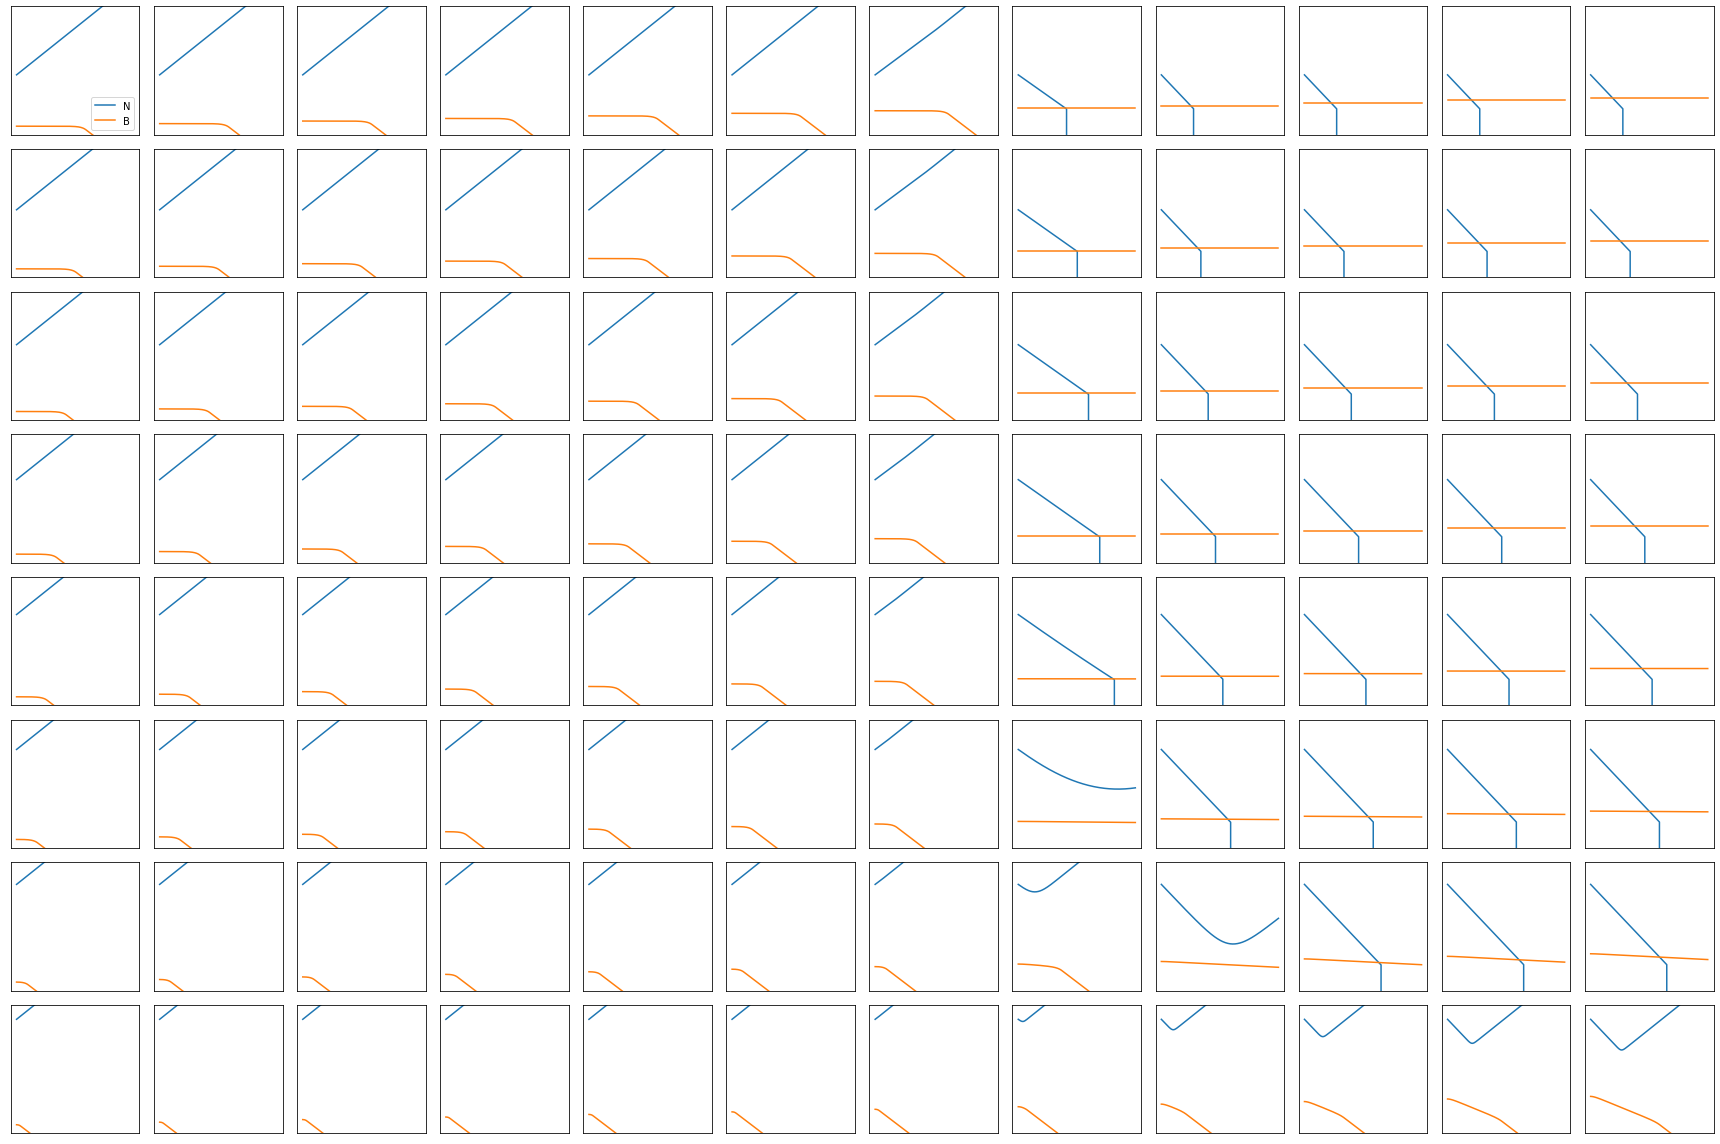

In [5]:
fig,ax = plt.subplots(8,12, figsize = (24,16))
for i in range(8):
    for j in range(12):
        ax[i,j].plot(pdyn.Trajectories[12*i + j][2].index,pdyn.Trajectories[12*i + j][2]['N'], label = 'N')
        ax[i,j].plot(pdyn.Trajectories[12*i + j][2].index,pdyn.Trajectories[12*i + j][2]['B'], label = 'B')
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylim([1e-3,1e12])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
ax[0,0].legend()
fig.tight_layout()

In [6]:
n0list = 1e4 * 8**np.arange(8)
b0list = 1e-1 * 2**np.arange(12)

pdynInt = PDC.EnzymePopulationDynamicsInternal(**params_internal)
final_popsize_int = []

for n0 in n0list:
    for b0 in b0list:
        pdynInt.Reset(N = n0, Bout = b0)
        t = pdynInt.Run(runtime = 48)
        final_popsize_int.append(t['N'].dropna().values[-1])
        print('{:.3e} {:.3e} {:.3e}'.format(n0,b0,final_popsize_int[-1]))



1.000e+04 1.000e-01 4.120e+14
1.000e+04 2.000e-01 4.120e+14
1.000e+04 4.000e-01 4.120e+14
1.000e+04 8.000e-01 4.120e+14
1.000e+04 1.600e+00 4.120e+14
1.000e+04 3.200e+00 4.119e+14
1.000e+04 6.400e+00 3.936e+14
1.000e+04 1.280e+01 3.921e+14
1.000e+04 2.560e+01 0.000e+00
1.000e+04 5.120e+01 0.000e+00
1.000e+04 1.024e+02 0.000e+00
1.000e+04 2.048e+02 0.000e+00
8.000e+04 1.000e-01 4.044e+14
8.000e+04 2.000e-01 4.044e+14
8.000e+04 4.000e-01 4.044e+14
8.000e+04 8.000e-01 4.044e+14
8.000e+04 1.600e+00 4.044e+14
8.000e+04 3.200e+00 4.043e+14
8.000e+04 6.400e+00 4.324e+14
8.000e+04 1.280e+01 4.153e+14
8.000e+04 2.560e+01 0.000e+00
8.000e+04 5.120e+01 0.000e+00
8.000e+04 1.024e+02 0.000e+00
8.000e+04 2.048e+02 0.000e+00
6.400e+05 1.000e-01 3.970e+14
6.400e+05 2.000e-01 3.970e+14
6.400e+05 4.000e-01 3.970e+14
6.400e+05 8.000e-01 3.970e+14
6.400e+05 1.600e+00 3.970e+14
6.400e+05 3.200e+00 3.969e+14
6.400e+05 6.400e+00 4.278e+14
6.400e+05 1.280e+01 3.928e+14
6.400e+05 2.560e+01 0.000e+00
6.400e+05 

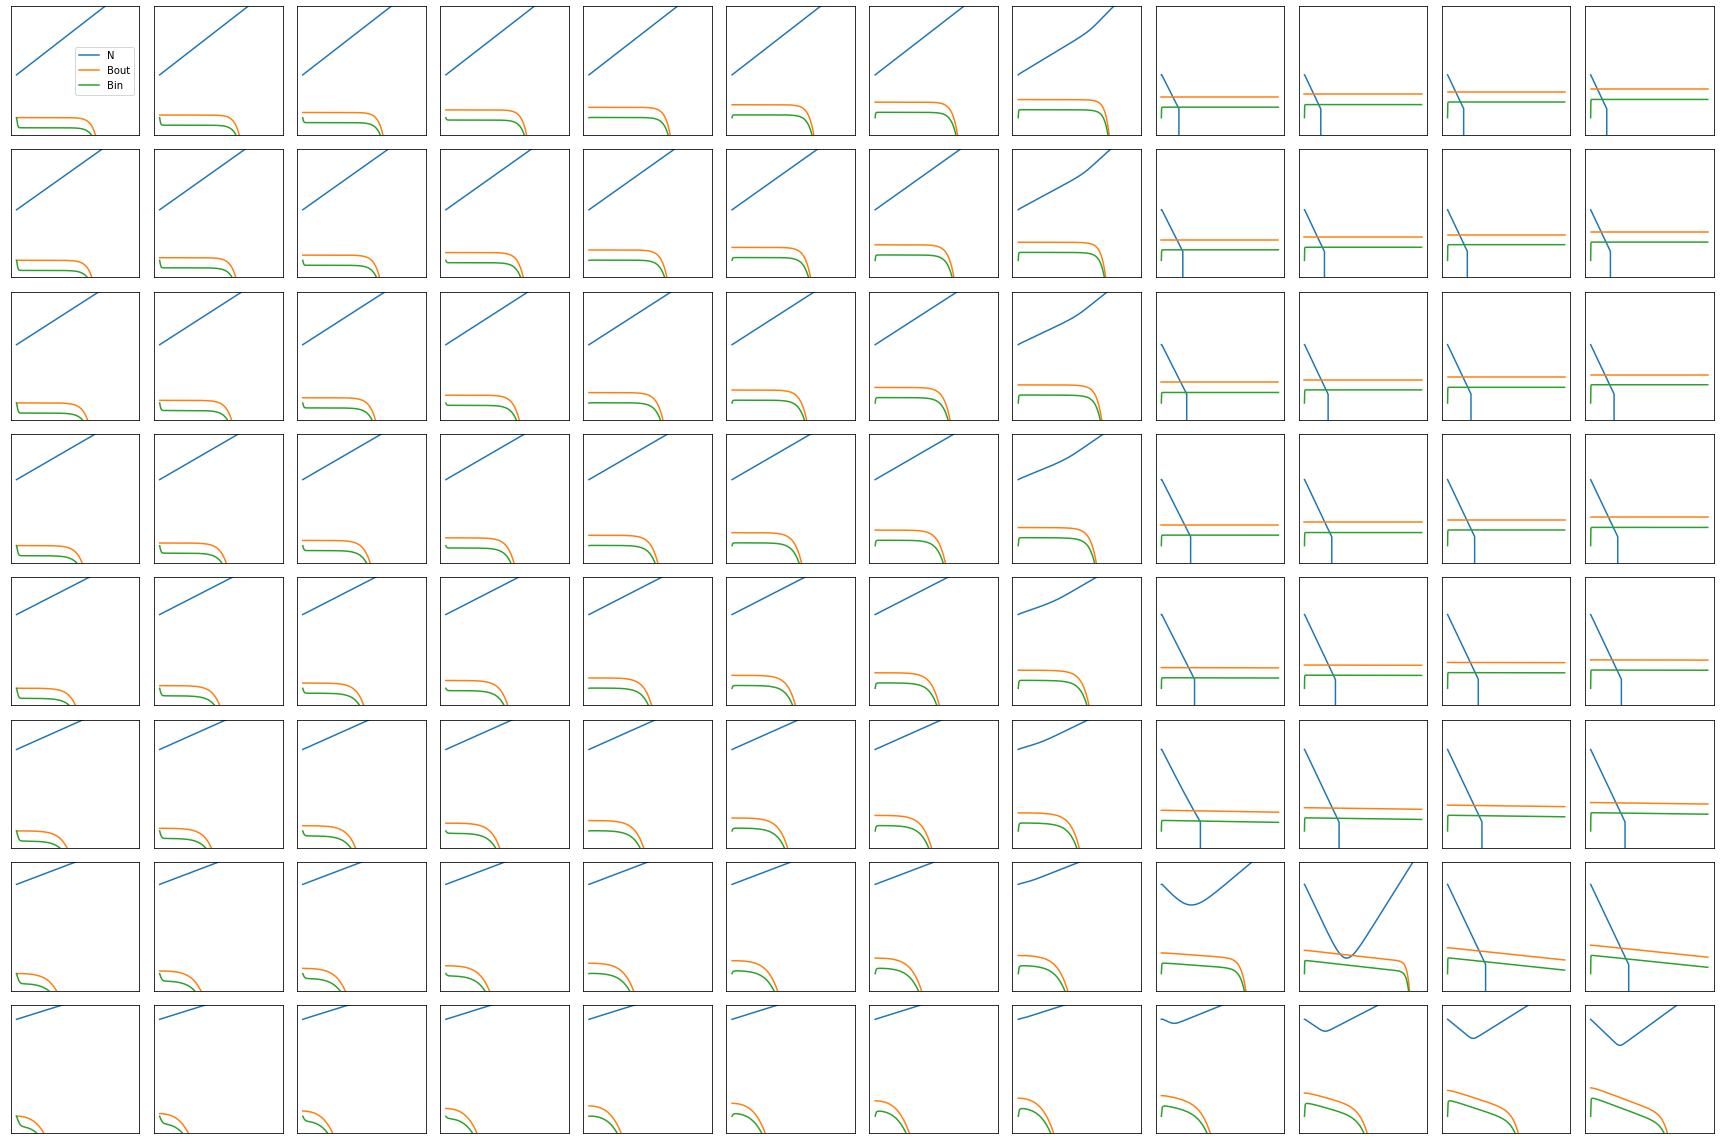

In [7]:
fig,ax = plt.subplots(8,12, figsize = (24,16))
for i in range(8):
    for j in range(12):
        ax[i,j].plot(pdynInt.Trajectories[12*i + j][2].index,pdynInt.Trajectories[12*i + j][2]['N'], label = 'N')
        ax[i,j].plot(pdynInt.Trajectories[12*i + j][2].index,pdynInt.Trajectories[12*i + j][2]['Bout'], label = 'Bout')
        ax[i,j].plot(pdynInt.Trajectories[12*i + j][2].index,pdynInt.Trajectories[12*i + j][2]['Bin'], label = 'Bin')
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylim([1e-3,1e12])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
ax[0,0].legend()
fig.tight_layout()

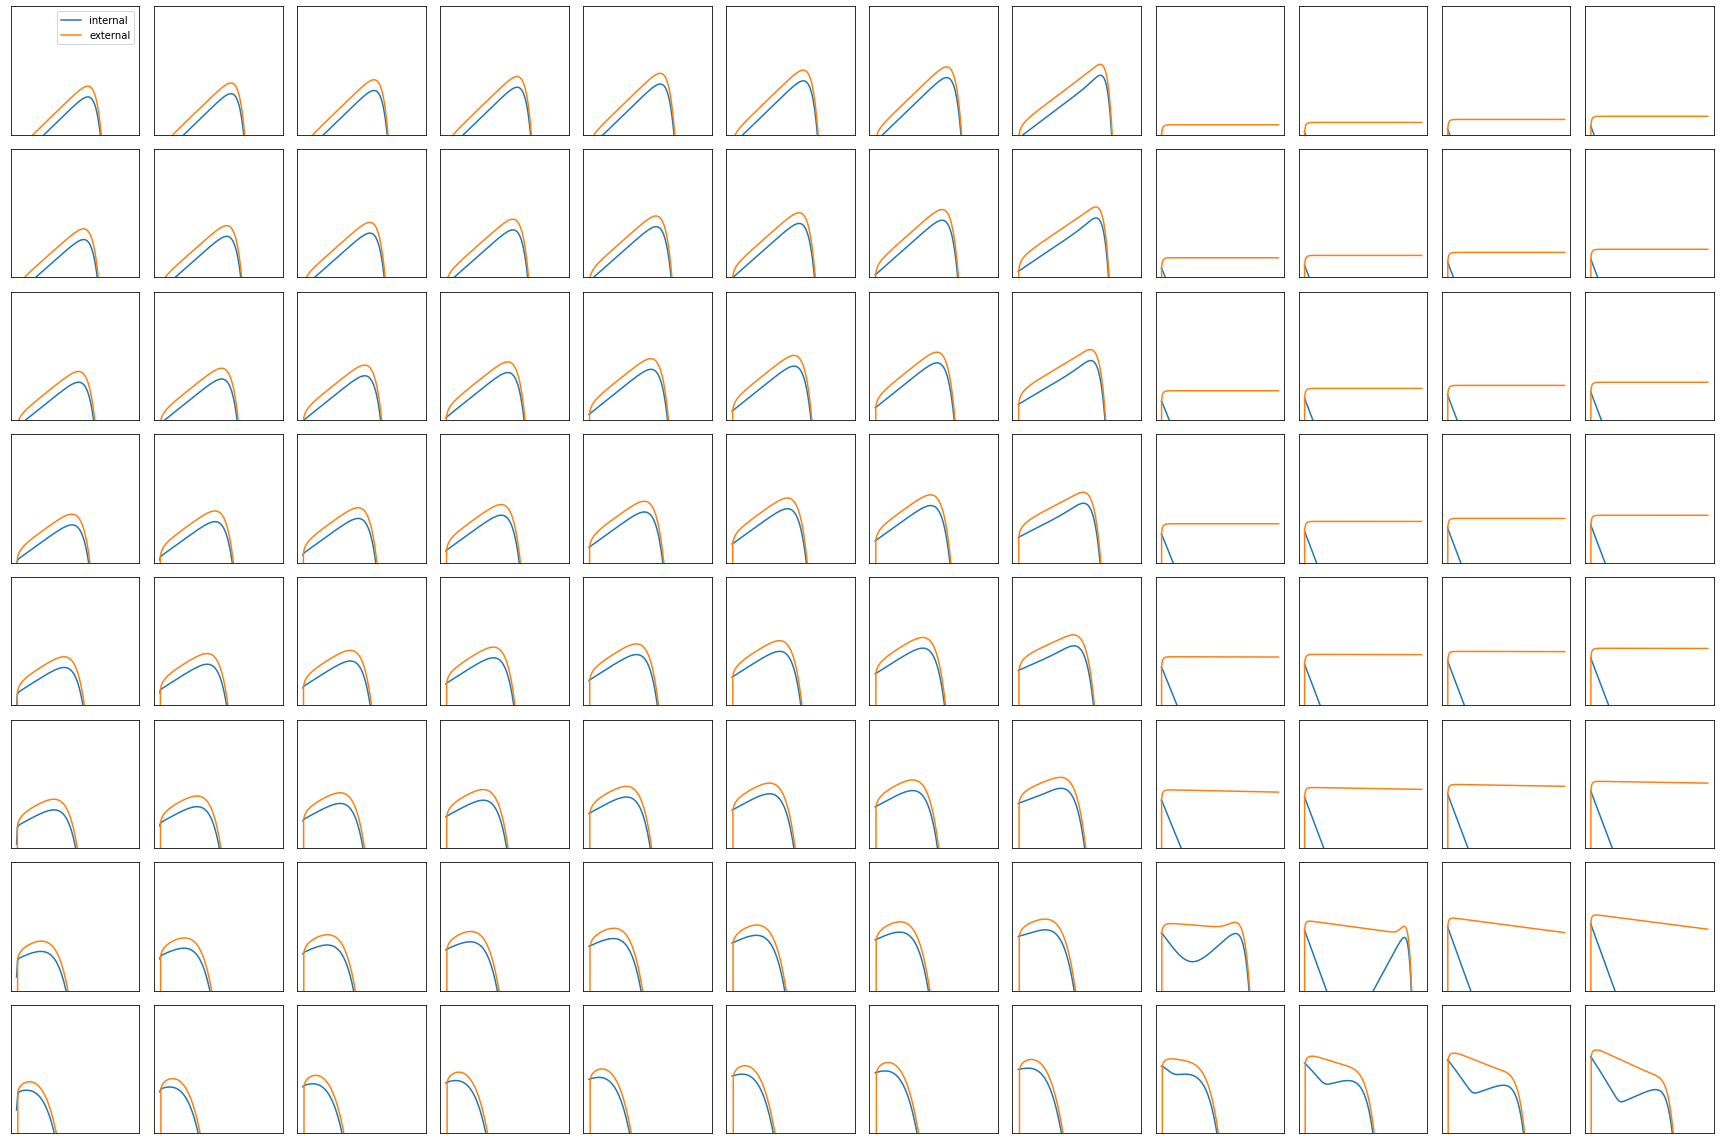

In [8]:
fig,ax = plt.subplots(8,12, figsize = (24,16))
for i in range(8):
    for j in range(12):
        params   = pdynInt.Trajectories[12*i + j][0]
        t        = pdynInt.Trajectories[12*i + j][2]
        internal = params['sigmaB'] * params['eta'] * t['N'] * (t['Bout'] - t['Bin'])
        external = params['epsilon'] * t['Eout'] * t['Bout']
        time     = t.index.values
        
        ax[i,j].plot(time, internal, label = 'internal')
        ax[i,j].plot(time, external, label = 'external')
        ax[i,j].set_yscale('log')
        ax[i,j].set_ylim([1e-6,1e6])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
ax[0,0].legend()
fig.tight_layout()